# 1

#### En el ejemplo de teoría hemos visto la forma de entrenar utilizando un trozo de datos como en la imagen "way1.png". 

(Básicamente, tener en cuenta más datos de entrenamiento [[20% de test]])

Investiga la forma de realizar el ejercicio a partir del gif "way3_sliding_window.gif":

- ¿Da mejores resultados entrenar el modelo así?

### Way#2

Con este modelo en el fit, la primera vez te voy a  dar algo del pasado y tienes que predecir algo que esta un poco más allá en  el futuro, luego como cjto de entrenamiento tienes lo que tenias del pasado, mas lo que tuviste que predecir, para que ahora predigas el futuro; te voy enseñando de poco en poco como es la evolución del pasado hasta el presente.

In [1]:
#importamos librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

#### Partition Train/Test splits

In [33]:
# Total time points
N = 3000

#partition all data 

P = int(N/3)

# firt partition
tp1 = int(0.7 * P)

# second partition
P2 = int(1.5 * P )
tp2 = P


#third partition
P3 = N
tp3 = P2

# Time point to partition train/test splits
t = np.arange(0,N)
x = (2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])
len(df)

3000

In [34]:
print("All my data points are:", N)
print("first partition: data", P,"my train/test :", tp1)
print("second partition: data", P2,"my train/test :", tp2)
print("third partition: data", P3,"my train/test :", tp3)

All my data points are: 3000
first partition: data 1000 my train/test : 700
second partition: data 1500 my train/test : 1000
third partition: data 3000 my train/test : 1500


In [38]:
# set train/test
def split(Tp, P):
    train, test = values[0:Tp ,:], values[Tp:P,:]
    return train, test

In [43]:
train1, test1 = split(Tp=tp1, P=P)

In [45]:
train2, test2 = split(Tp=tp2, P=P2)

In [46]:
train3, test3 = split(Tp=tp3, P=P3)

In [41]:
#show set data train/test
def show_data_plot(df,Tp,P, train, test):
    index = df.index.values
    plt.figure(figsize=(15,4))
    plt.plot(index[0:Tp],train,c='blue')
    plt.plot(index[Tp:P],test,c='orange',alpha=0.7)
    plt.legend(['Train','Test'])
    plt.axvline(df.index[Tp], c="r")
    plt.grid(True)
    
    return plt.show()

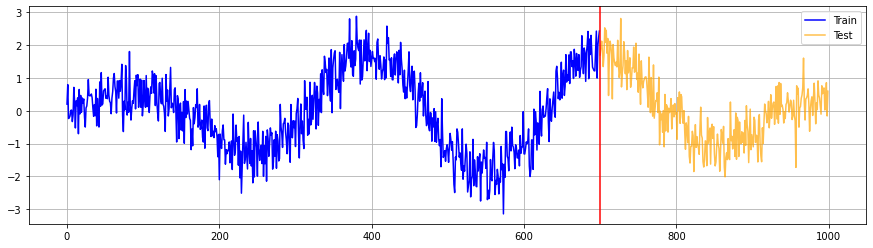

In [44]:
show_data_plot(df=df, Tp=tp1, P = P, train= train1, test=test1)

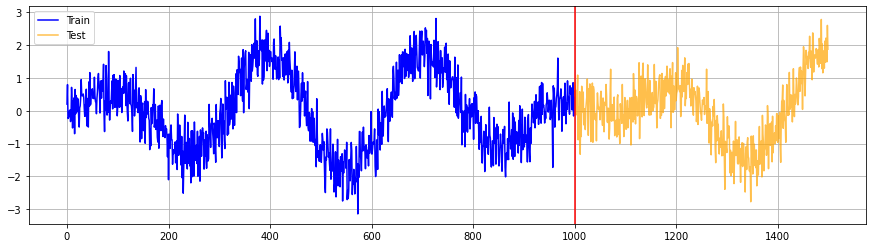

In [47]:
show_data_plot(df=df, Tp=tp2, P = P2, train= train2, test=test2)

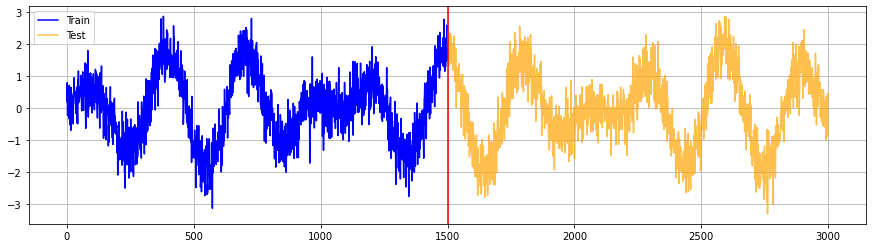

In [48]:
show_data_plot(df=df, Tp=tp3, P = P3, train= train3, test=test3)

In [49]:
# number of step
def step(n_step,train, test ):
    
    test = np.append(test, np.repeat(test[-1,],n_step))
    train = np.append(train, np.repeat(train[-1,],n_step))

    return train, test

In [50]:
train1,test1 = step(4,train1, test1)

In [51]:
def convert_to_matrix(data, step):
    X, Y = [], []
    for i in range(len(data)-step):
        d = i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [52]:
n_step = 4

trainX, trainY = convert_to_matrix(train1,step= n_step)
testX, testY = convert_to_matrix(test1,step= n_step)

trainX.shape

(700, 4)

In [53]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [54]:
trainX.shape

(700, 1, 4)

In [55]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (700, 1, 4) ,  (700,)
Test data shape: (300, 1, 4) ,  (300,)


#### Keras model with SimpleRNN layer

In [56]:
def build_simple_rnn(num_units=128, embedding=4, num_dense=32, lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length - Steps - Tamaño de ventana
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1, embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [57]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

In [67]:
#training

batch_size=16
num_epochs = 1000

def fit_model(trainX,trainY, num_epochs,batch_size,model):
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

In [ ]:
# num_units=128, embedding=4, num_dense=32, lr=0.001
# batch_size=16
# num_epochs = 1000
#convert_to_matrix(data, step)

In [68]:
# main funtion that return my set train/test partition with the RNN model and RMSE

def my_model_trained(Tp, P, train, test, n_step,num_units, embedding, num_dense, lr, batch_size, num_epochs):
    train, test = split(Tp, P)
    train, test = step(n_step,train, test )

    
    trainX, trainY = convert_to_matrix(train,step= n_step)
    testX, testY = convert_to_matrix(test,step= n_step)

    #reshape
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    #model
    model = build_simple_rnn(num_units, embedding, num_dense, lr)

    class MyCallback(Callback):
        def on_epoch_end(self, epoch, logs=None):
            if (epoch+1) % 50 == 0 and epoch>0:
                print("Epoch number {} done".format(epoch+1))


    fit_model(trainX,trainY, num_epochs,batch_size, model)

    #Accuracy

    test_loss, test_acc = model.evaluate(testX, testY, verbose=2)
    return ('\nTest accuracy:', test_acc)


In [69]:
# 1st partition
accuracy1 = my_model_trained(Tp= tp1, P= P, n_step=4, train=train1, test=test1, num_units=128, embedding=4, num_dense=32, lr=0.001, batch_size=16, num_epochs=1000)
accuracy1

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done
10/10 - 0s - loss: 0.5784 - mse: 0.5784


('\nTest accuracy:', 0.5783787369728088)

In [70]:
# Second partition
accuracy2 = my_model_trained(Tp= tp2, P= P2, n_step=4, train=train2, test=test2, num_units=128, embedding=4, num_dense=32, lr=0.001, batch_size=16, num_epochs=1000)
accuracy2

C:\Users\Karina\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done
16/16 - 0s - loss: 0.5745 - mse: 0.5745


('\nTest accuracy:', 0.5745291709899902)

In [71]:
# Third partition
accuracy3 = my_model_trained(Tp= tp3, P= P3, n_step=4, train=train3, test=test3, num_units=128, embedding=4, num_dense=32, lr=0.001, batch_size=16, num_epochs=1000)
accuracy3

C:\Users\Karina\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done
47/47 - 0s - loss: 0.5840 - mse: 0.5840


('\nTest accuracy:', 0.5839832425117493)

In [72]:

import pandas as pd 
list_acc = [accuracy1[1], accuracy2[1], accuracy3[1]]
df = pd.DataFrame(list_acc, columns=["Accuracy"])
df

,Accuracy
0,0.578379
1,0.574529
2,0.583983
